In [1]:

#src->dataset contains program to download,transform and prepare the dataset

"""
src->dataset->download_dataset contains class for downloading and unpacking
datasets for
    -- Mini CoCo dataset : Downloaded and extracted from an github repo
    -- CIFAR-100 dataset : Downloaded through torchvision library
    -- OxfordIIITPet dataset : Downloaded through torchvision library
"""

# if you encounter error (I usually observe this on cloud gpu notebooks): please try
# pip install -U --no-cache-dir gdown --pre 

from src.dataset import download_dataset

#:param dataset_name: can be "mini_coco","cifar","oxford_pet"
train_dataset_downloader=download_dataset.DownloadDataset(dataset_name="mini_coco")
train_dataset_downloader.download_from_url(url='1t_l9uyBPfxSEzcajTk4a1TaQXzeRm9hw')

# train_dataset_downloader=download_dataset.DownloadDataset(dataset_name="cifar")
# train_dataset_downloader.download_from_torch()
#
# train_dataset_downloader=download_dataset.DownloadDataset(dataset_name="oxford_pet")
# train_dataset_downloader.download_from_torch()


Mini coco dataset from https://github.com/giddyyupp/coco-minitrain repo


Downloading...
From: https://drive.google.com/uc?id=1t_l9uyBPfxSEzcajTk4a1TaQXzeRm9hw
To: /notebooks/Poly2/data/raw/dataset.zip
100%|██████████| 4.90G/4.90G [01:09<00:00, 70.2MB/s]



 Finished downloading and unpacking Mini coco dataset


In [1]:
#src->dataset contains program to download,transform and prepare the dataset

"""
src->dataset->prepare_dataset contains functions to load input images and sobel/random filter images

image folder for "mini_coco" : "data/raw/coco_minitrain_25k/images/train2017"
image folder for "oxford pet" : "data/raw/oxford-iiit-pet/images"

image size of 64 is used for the Autoencoder and 128 is used for the Pix2Pix Model

filter can be "sobel" to apply sobel filter
"random" to apply random filter (extra credit)

this interim data is stored in static location- data->interim for simplification
"""

from src.dataset import prepare_dataset
images,ground_truths=prepare_dataset.prepare_img_and_gt_folder(folder="data/raw/coco_minitrain_25k/images/train2017",
                                                        img_size=64,
                                                        filter="sobel",
                                                        save=True)

In [ ]:
# Visualizing images and corresponding filtered images

import matplotlib.pyplot as plt
for i in range(5):
    plt.imshow(images[i])
    plt.show()

    plt.imshow(ground_truths[i],cmap="gray")
    plt.show()

In [1]:
#src->dataset contains program to download,transform and prepare the dataset

from src.dataset import prepare_dataset
from src.dataset import load_torch_dataset
from torchvision import transforms

# to save time, we can load from interim itself
import numpy as np
images=np.load("data/interim/images.npy")
ground_truths=np.load("data/interim/ground_truths.npy")

"""
src->prepare_dataset contains
:func :randomly_select, which can be used to select random portion of the dataset
in the view of GPU memory limitation

:func :split_dataset contains code to split the dataset into training,testing and validation
"""

images,ground_truths=prepare_dataset.randomly_select(images=images,gts=ground_truths,n=10000)

train_images,val_images,test_images\
,train_ground_truths,val_ground_truths,test_ground_truths=prepare_dataset.split_data(images=images,gts=ground_truths,test_size=0.2,val_size=0.25)

"""
src->load_torch_dataset provide Custom Pytorch Dataset Class tailored for this project
"""
train_dataset=load_torch_dataset.Img2ImgDataset(train_images,train_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))
val_dataset=load_torch_dataset.Img2ImgDataset(val_images,val_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset=load_torch_dataset.Img2ImgDataset(test_images,test_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))

Epoch: 1
train loss: 0.3690475523471832
train psnr: 3.20855975151062
train ssim: 0.3871763050556183
val loss: 0.1943773627281189
val psnr: 11.40970516204834
val ssim: 0.01981533318758011
Epoch: 2
train loss: 0.3488156497478485
train psnr: 3.6724655628204346
train ssim: 0.4183257818222046
val loss: 0.18268243968486786
val psnr: 11.907560348510742
val ssim: 0.10434506833553314
Epoch: 3
train loss: 0.3184609115123749
train psnr: 4.800666809082031
train ssim: 0.4307321310043335
val loss: 0.17238470911979675
val psnr: 11.937366485595703
val ssim: 0.3942565619945526
Epoch: 4
train loss: 0.2857970893383026
train psnr: 6.198343276977539
train ssim: 0.4253617525100708
val loss: 0.1996219903230667
val psnr: 9.953520774841309
val ssim: 0.4575918912887573
Epoch: 5
train loss: 0.2558881342411041
train psnr: 7.687784671783447
train ssim: 0.41306594014167786
val loss: 0.21880659461021423
val psnr: 9.297204971313477
val ssim: 0.4333534240722656
Epoch: 6
train loss: 0.2309931069612503
train psnr: 8.991

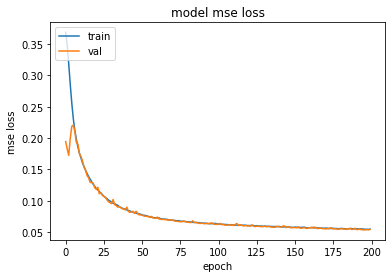

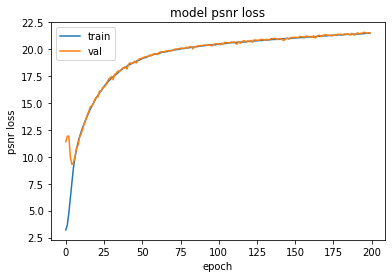

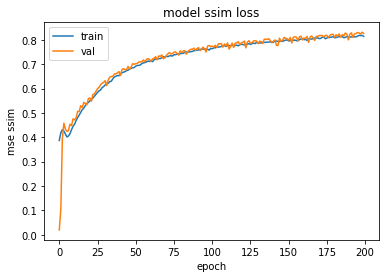

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim

"""
This section code for Model Defintion, Hyper-paramter setting and Training
"""


class Net(nn.Module):
    """
    Simple Convolution Autoencoder
    """
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.batch_norm1=nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.batch_norm2=nn.BatchNorm2d(32)
        self.trans_conv1=torch.nn.ConvTranspose2d(32,16,3)
        self.batch_norm3=nn.BatchNorm2d(16)
        self.trans_conv2=torch.nn.ConvTranspose2d(16,1,3)
        self.batch_norm4=nn.BatchNorm2d(1)


    def forward(self, x):
        x = self.conv1(x)
        x= F.relu(self.batch_norm1(x))
        x = self.conv2(x)
        x= F.relu(self.batch_norm2(x))
        x = self.trans_conv1(x)
        x= F.relu(self.batch_norm3(x))
        x = self.trans_conv2(x)
        x= F.relu(self.batch_norm4(x))
        return x

net = Net()

# Hyper parameter selection
epochs=200
batch_size=512
learning_rate=0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = torch.optim.Adam(net.parameters(),
                        lr=learning_rate,
                        betas=(0.5,0.999))
L1_criterion = nn.L1Loss()


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

net=net.to(device)

total_loss=[]
total_psnr=[]
total_ssim=[]

total_loss_val=[]
total_psnr_val=[]
total_ssim_val=[]

for epoch in range(epochs):


    loss_epoch=[]
    loss_epoch_val=[]

    psnr_epoch=[]
    psnr_epoch_val=[]

    ssim_epoch=[]
    ssim_epoch_val=[]


    net.train()
    for i, data in enumerate(train_dataloader):


        image,target=data
        image=image.to(device)
        target=target.to(device)

        optim.zero_grad()

        #  forward pass
        predicted = net(image)
        loss= L1_criterion(predicted,target)

        loss.backward()
        optim.step()

        psnr_train = psnr(predicted, target)
        ssim_train = ssim(predicted, target)

        loss_epoch.append(float(loss.detach().cpu()))
        psnr_epoch.append(float(psnr_train.detach().cpu()))
        ssim_epoch.append(float(ssim_train.detach().cpu()))




    net.eval()
    for i, data in enumerate(val_dataloader):

        image,target=data
        image=image.to(device)
        target=target.to(device)

        predicted = net(image)
        loss= L1_criterion(predicted,target)


        psnr_val = psnr(predicted, target)
        ssim_val = ssim(predicted, target)


        loss_epoch_val.append(float(loss.detach().cpu()))
        psnr_epoch_val.append(float(psnr_val.detach().cpu()))
        ssim_epoch_val.append(float(ssim_val.detach().cpu()))


    print("Epoch: "+str(epoch+1))
    print("train loss: "+str(float(torch.mean(torch.tensor(loss_epoch)))))
    print("train psnr: "+str(float(torch.mean(torch.tensor(psnr_epoch)))))
    print("train ssim: "+str(float(torch.mean(torch.tensor(ssim_epoch)))))

    total_loss.append(float(torch.mean(torch.tensor(loss_epoch))))
    total_psnr.append(float(torch.mean(torch.tensor(psnr_epoch))))
    total_ssim.append(float(torch.mean(torch.tensor(ssim_epoch))))

    print("val loss: "+str(float(torch.mean(torch.tensor(loss_epoch_val)))))
    print("val psnr: "+str(float(torch.mean(torch.tensor(psnr_epoch_val)))))
    print("val ssim: "+str(float(torch.mean(torch.tensor(ssim_epoch_val)))))

    total_loss_val.append(float(torch.mean(torch.tensor(loss_epoch_val))))
    total_psnr_val.append(float(torch.mean(torch.tensor(psnr_epoch_val))))
    total_ssim_val.append(float(torch.mean(torch.tensor(ssim_epoch_val))))



import matplotlib.pyplot as plt

# Plot and label the training and validation loss values
plt.plot(total_loss)
plt.plot(total_loss_val)
plt.title("model mse loss")
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot and label the training and validation psnr values
plt.plot(total_psnr)
plt.plot(total_psnr_val)
plt.title("model psnr loss")
plt.ylabel('psnr loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot and label the training and validation ssim values
plt.plot(total_ssim)
plt.plot(total_ssim_val)
plt.title("model ssim loss")
plt.ylabel('mse ssim')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [3]:
# Testing the network with test dataset

net.eval()
for i, data in enumerate(test_dataloader):

    image,target=data
    image=image.to(device)
    target=target.to(device)

    predicted = net(image)
    loss= L1_criterion(predicted,target)

    psnr_test = psnr(predicted, target)
    ssim_test = ssim(predicted, target)

print("Test Loss: "+str(float(loss.detach().cpu())))
print("Test PSNR: "+str(float(psnr_test.detach().cpu())))
print("Test SSIM: "+str(float(ssim_test.detach().cpu())))

Test Loss: 0.05406247079372406
Test PSNR: 21.546340942382812
Test SSIM: 0.8205837607383728


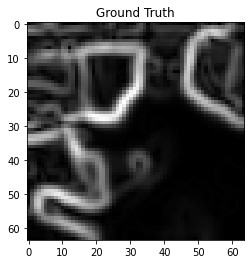

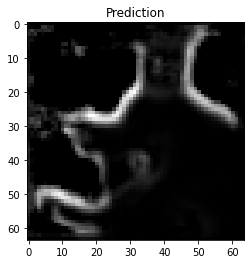

In [4]:
# Visualizing single test image
import matplotlib.pyplot as plt

test_image=test_images[50]
gt_image=test_ground_truths[50]

plt.imshow(gt_image,cmap="gray")
plt.title("Ground Truth")
plt.show()

gt_image=np.expand_dims(gt_image,2)

test_image=torch.tensor(test_image).permute(2,0,1).unsqueeze(0).cuda().float()
gt_image=torch.tensor(gt_image).permute(2,0,1).unsqueeze(0).cuda()

net.eval()
predicted=net(test_image).detach().cpu()

plt.imshow(predicted[0][0],cmap="gray")
plt.title("Prediction")
plt.show()

In [1]:
"""
Extra Credit Using Random Image Filter
"""

from src.dataset import prepare_dataset
images,ground_truths=prepare_dataset.prepare_img_and_gt_folder(folder="data/raw/coco_minitrain_25k/images/train2017",
                                                        img_size=64,
                                                        filter="random",
                                                        save=False)

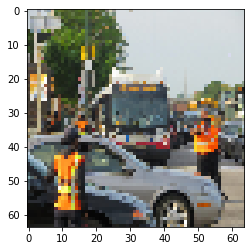

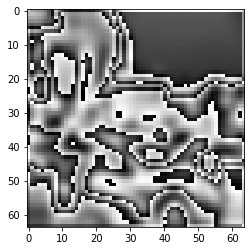

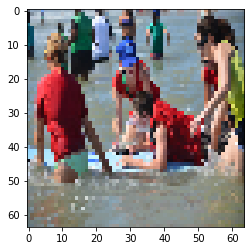

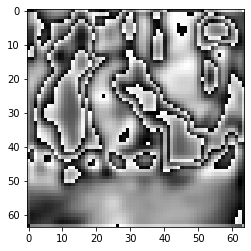

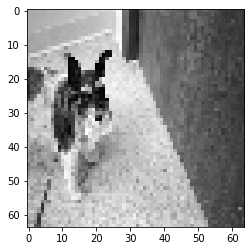

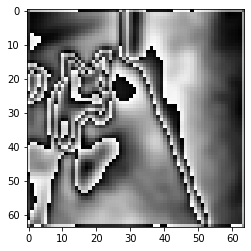

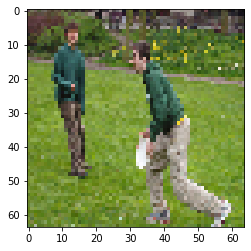

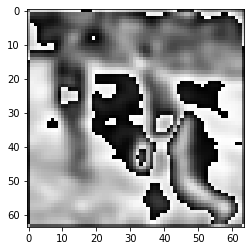

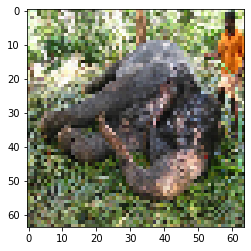

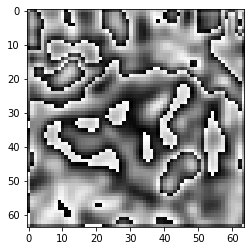

In [2]:
import matplotlib.pyplot as plt
for i in range(5):
    plt.imshow(images[i])
    plt.show()

    plt.imshow(ground_truths[i],cmap="gray")
    plt.show()

In [3]:
from src.dataset import prepare_dataset
from src.dataset import load_torch_dataset
from torchvision import transforms

images,ground_truths=prepare_dataset.randomly_select(images=images,gts=ground_truths,n=10000)

train_images,val_images,test_images\
,train_ground_truths,val_ground_truths,test_ground_truths=prepare_dataset.split_data(images=images,gts=ground_truths,test_size=0.2,val_size=0.25)

train_dataset=load_torch_dataset.Img2ImgDataset(train_images,train_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))
val_dataset=load_torch_dataset.Img2ImgDataset(val_images,val_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset=load_torch_dataset.Img2ImgDataset(test_images,test_ground_truths,transform=transforms.Compose([transforms.ToTensor()]))

Epoch: 1
train loss: 0.5208691954612732
train psnr: 3.3596222400665283
train ssim: 0.1649036407470703
val loss: 0.4327760934829712
val psnr: 5.751091957092285
val ssim: 0.02372152730822563
Epoch: 2
train loss: 0.44676220417022705
train psnr: 5.118459701538086
train ssim: 0.1444839984178543
val loss: 0.34099912643432617
val psnr: 7.542726516723633
val ssim: 0.07805783301591873
Epoch: 3
train loss: 0.4070972502231598
train psnr: 6.000850677490234
train ssim: 0.12449479103088379
val loss: 0.3608705699443817
val psnr: 7.043631076812744
val ssim: 0.10099797695875168
Epoch: 4
train loss: 0.38245394825935364
train psnr: 6.5281662940979
train ssim: 0.11766944080591202
val loss: 0.3668134808540344
val psnr: 6.874115943908691
val ssim: 0.13589857518672943
Epoch: 5
train loss: 0.3664496839046478
train psnr: 6.871364593505859
train ssim: 0.11754414439201355
val loss: 0.36764705181121826
val psnr: 6.857741832733154
val ssim: 0.13588403165340424
Epoch: 6
train loss: 0.3554430305957794
train psnr: 7.

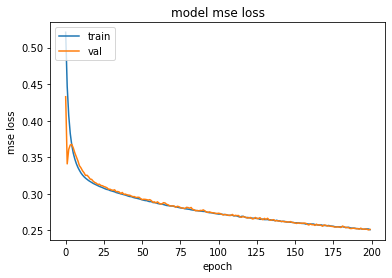

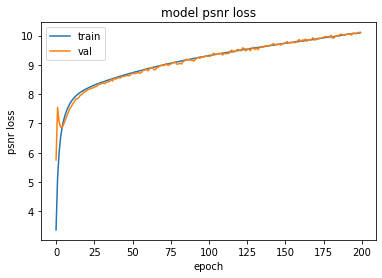

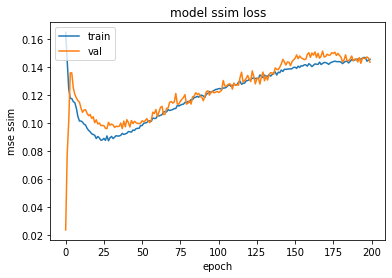

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim



class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.batch_norm1=nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.batch_norm2=nn.BatchNorm2d(32)
        
        self.trans_conv1=torch.nn.ConvTranspose2d(32,16,3)
        self.batch_norm3=nn.BatchNorm2d(16)
        
        self.trans_conv2=torch.nn.ConvTranspose2d(16,1,3)
        self.batch_norm4=nn.BatchNorm2d(1)


    def forward(self, x):
        x = self.conv1(x)
        x= F.relu(self.batch_norm1(x))
        
        x = self.conv2(x)
        x= F.relu(self.batch_norm2(x))
        
        x = self.trans_conv1(x)
        x= F.relu(self.batch_norm3(x))
        
        x = self.trans_conv2(x)
        x= F.relu(self.batch_norm4(x))
        return x

net = Net()

# Hyper parameter selection
epochs=200
batch_size=512
learning_rate=0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = torch.optim.Adam(net.parameters(),
                        lr=learning_rate,
                        betas=(0.5,0.999))
L1_criterion = nn.L1Loss()


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

net=net.to(device)

total_loss=[]
total_psnr=[]
total_ssim=[]

total_loss_val=[]
total_psnr_val=[]
total_ssim_val=[]

for epoch in range(epochs):


    loss_epoch=[]
    loss_epoch_val=[]

    psnr_epoch=[]
    psnr_epoch_val=[]

    ssim_epoch=[]
    ssim_epoch_val=[]


    net.train()
    for i, data in enumerate(train_dataloader):


        image,target=data
        image=image.to(device)
        target=target.to(device)

        optim.zero_grad()

        #  forward pass
        predicted = net(image)
        loss= L1_criterion(predicted,target)

        loss.backward()
        optim.step()

        psnr_train = psnr(predicted, target)
        ssim_train = ssim(predicted, target)

        loss_epoch.append(float(loss.detach().cpu()))
        psnr_epoch.append(float(psnr_train.detach().cpu()))
        ssim_epoch.append(float(ssim_train.detach().cpu()))




    net.eval()
    for i, data in enumerate(val_dataloader):

        image,target=data
        image=image.to(device)
        target=target.to(device)

        predicted = net(image)
        loss= L1_criterion(predicted,target)


        psnr_val = psnr(predicted, target)
        ssim_val = ssim(predicted, target)


        loss_epoch_val.append(float(loss.detach().cpu()))
        psnr_epoch_val.append(float(psnr_val.detach().cpu()))
        ssim_epoch_val.append(float(ssim_val.detach().cpu()))

    # dataloader loop over
    print("Epoch: "+str(epoch+1))
    print("train loss: "+str(float(torch.mean(torch.tensor(loss_epoch)))))
    print("train psnr: "+str(float(torch.mean(torch.tensor(psnr_epoch)))))
    print("train ssim: "+str(float(torch.mean(torch.tensor(ssim_epoch)))))

    total_loss.append(float(torch.mean(torch.tensor(loss_epoch))))
    total_psnr.append(float(torch.mean(torch.tensor(psnr_epoch))))
    total_ssim.append(float(torch.mean(torch.tensor(ssim_epoch))))

    print("val loss: "+str(float(torch.mean(torch.tensor(loss_epoch_val)))))
    print("val psnr: "+str(float(torch.mean(torch.tensor(psnr_epoch_val)))))
    print("val ssim: "+str(float(torch.mean(torch.tensor(ssim_epoch_val)))))

    total_loss_val.append(float(torch.mean(torch.tensor(loss_epoch_val))))
    total_psnr_val.append(float(torch.mean(torch.tensor(psnr_epoch_val))))
    total_ssim_val.append(float(torch.mean(torch.tensor(ssim_epoch_val))))



import matplotlib.pyplot as plt

# Plot and label the training and validation loss values
plt.plot(total_loss)
plt.plot(total_loss_val)
plt.title("model mse loss")
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot and label the training and validation psnr values
plt.plot(total_psnr)
plt.plot(total_psnr_val)
plt.title("model psnr loss")
plt.ylabel('psnr loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot and label the training and validation ssim values
plt.plot(total_ssim)
plt.plot(total_ssim_val)
plt.title("model ssim loss")
plt.ylabel('mse ssim')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [5]:
# Testing the network with test dataset

net.eval()
for i, data in enumerate(test_dataloader):

    image,target=data
    image=image.to(device)
    target=target.to(device)

    predicted = net(image)
    loss= L1_criterion(predicted,target)

    psnr_test = psnr(predicted, target)
    ssim_test = ssim(predicted, target)

print("Test Loss: "+str(float(loss.detach().cpu())))
print("Test PSNR: "+str(float(psnr_test.detach().cpu())))
print("Test SSIM: "+str(float(ssim_test.detach().cpu())))

Test Loss: 0.25272947549819946
Test PSNR: 10.065942764282227
Test SSIM: 0.1438533067703247


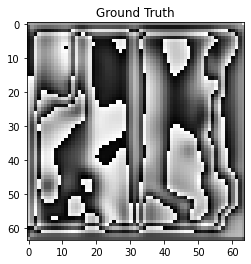

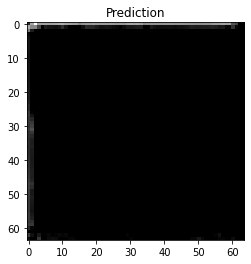

In [7]:
# Visualizing single test image
import numpy as np

test_image=test_images[100]
gt_image=test_ground_truths[100]

plt.imshow(gt_image,cmap="gray")
plt.title("Ground Truth")
plt.show()

gt_image=np.expand_dims(gt_image,2)

test_image=torch.tensor(test_image).permute(2,0,1).unsqueeze(0).cuda().float()
gt_image=torch.tensor(gt_image).permute(2,0,1).unsqueeze(0).cuda()

net.eval()
predicted=net(test_image).detach().cpu()

plt.imshow(predicted[0][0],cmap="gray")
plt.title("Prediction")
plt.show()

In [ ]:
# Extra Code
# class Net(nn.Module):
#     """
#     Pytorch Module for defining an simple autoencoder
#     """
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3)
#         self.batch_norm1=nn.BatchNorm2d(16)
#         self.trans_conv1=nn.ConvTranspose2d(16,1,3)
#         self.batch_norm2=nn.BatchNorm2d(1)

#     def forward(self, x):
#         x = self.conv1(x)
#         x= F.relu(self.batch_norm1(x))
#         x = self.trans_conv1(x)
#         x= F.relu(self.batch_norm2(x))
#         return x
    
# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3)
#         self.batch_norm1=nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, 3)
#         self.batch_norm2=nn.BatchNorm2d(32)
#         self.conv3=nn.Conv2d(32,64,3)
#         self.batch_norm3=nn.BatchNorm2d(64)
        
#         self.trans_conv1=torch.nn.ConvTranspose2d(64,32,3)
#         self.batch_norm4=nn.BatchNorm2d(32)
#         self.trans_conv2=torch.nn.ConvTranspose2d(32,16,3)
#         self.batch_norm5=nn.BatchNorm2d(16)
#         self.trans_conv3=torch.nn.ConvTranspose2d(16,1,3)
#         self.batch_norm6=nn.BatchNorm2d(1)

#     def forward(self, x):
        
#         x = self.conv1(x)
#         x= F.relu(self.batch_norm1(x))
#         x = self.conv2(x)
#         x= F.relu(self.batch_norm2(x))
#         x = self.conv3(x)
#         x= F.relu(self.batch_norm3(x))
        
#         x = self.trans_conv1(x)
#         x= F.relu(self.batch_norm4(x))
#         x = self.trans_conv2(x)
#         x= F.relu(self.batch_norm5(x))
#         x = self.trans_conv3(x)
#         x= F.relu(self.batch_norm6(x))
        
#         return x